In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Load dataset
df = pd.read_csv('./data/categorized_specializations.csv')

In [3]:
# Label encoding categorical columns
def encode_categorical_columns(df, categorical_columns):
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = df[col].astype(str)
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    return df, label_encoders

# Scaling continuous columns
def scale_numerical_columns(df, numerical_columns):
    scaler = StandardScaler()
    df[numerical_columns] = df[numerical_columns].replace([np.inf, -np.inf], np.nan)
    df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].mean())
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    return df, scaler

In [4]:
# Function to train ML models
def train_models(X_train, X_test, y_train, y_test, model_name_prefix):

    models = {
        "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
        "XGBoost": XGBClassifier(
            objective='multi:softprob', eval_metric='mlogloss', random_state=42,
            use_label_encoder=False, n_jobs=-1
        )
    }
    
    rf_param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    
    xgb_param_grid = {
        'max_depth': [3, 5, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'reg_alpha': [0.01, 0.1, 1],
        'reg_lambda': [0.01, 0.1, 1]
    }

    trained_models = {}
    le_y = LabelEncoder()
    y_train_encoded = le_y.fit_transform(y_train)
    y_test_encoded = le_y.transform(y_test)

    for name, model in models.items():
        print(f"\nTraining {name} for {model_name_prefix} Prediction")
        param_grid = rf_param_grid if name == "Random Forest" else xgb_param_grid
        random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                                           n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
        random_search.fit(X_train, y_train_encoded)
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_

        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test_encoded, y_pred)
        print(f"{name} Accuracy: {acc:.4f}")
        print(f"Best Parameters: {best_params}")
        print(classification_report(y_test_encoded, y_pred))

        # Plot feature importance
        if hasattr(best_model, 'feature_importances_'):
            plt.figure(figsize=(10, 6))
            importance_df = pd.DataFrame({
                'Feature': X_train.columns,
                'Importance': best_model.feature_importances_
            }).sort_values(by='Importance', ascending=False)
            print("Feature Importances:")
            print(importance_df.to_string(index=False))
            ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
            plt.title(f"{name} Feature Importance for {model_name_prefix}")
            # Annotate values on the bars
            for i, v in enumerate(importance_df['Importance']):
                ax.text(v, i, f"{v:.4f}", color='black', va='center')
            plt.show()
     
        trained_models[name] = (best_model, le_y)
    
    return trained_models, le_y



Training Random Forest for Specialization Prediction
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Random Forest Accuracy: 0.7753
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': False}
              precision    recall  f1-score   support

           0       0.62      0.93      0.74        14
           1       0.86      0.93      0.89        27
           2       0.64      0.49      0.56        91
           3       0.55      0.55      0.55        11
           4       0.54      0.70      0.61        10
           5       1.00      1.00      1.00         7
           6       0.81      0.93      0.87        28
           7       0.40      1.00      0.57         4
           8       0.89      0.48      0.63       297
           9       0.53      0.69      0.60        13
          10       0.46      0.75      0.57         8
          11       0.50      0.86      0.63         7
          12       0.75   

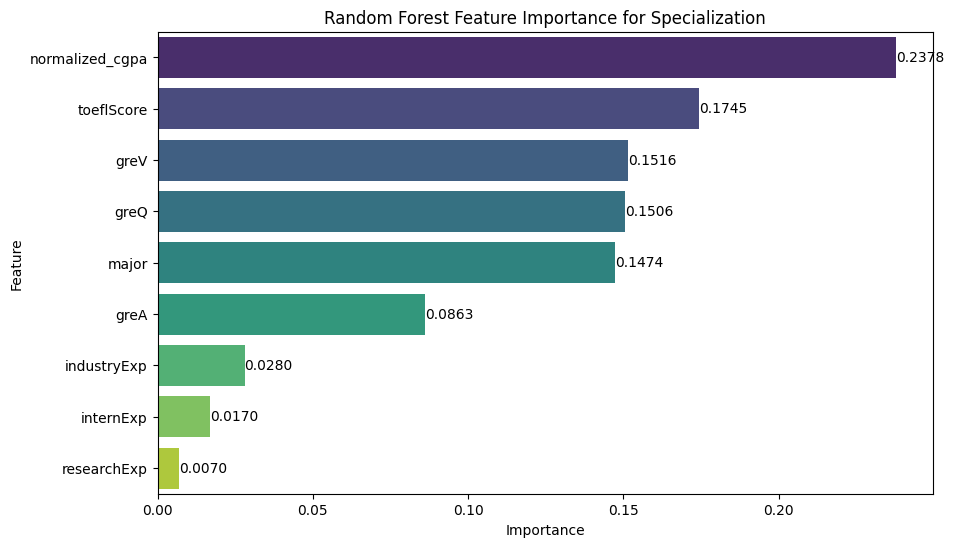


Training XGBoost for Specialization Prediction
Fitting 3 folds for each of 10 candidates, totalling 30 fits
XGBoost Accuracy: 0.7338
Best Parameters: {'subsample': 0.7, 'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
              precision    recall  f1-score   support

           0       0.53      0.64      0.58        14
           1       0.78      0.93      0.85        27
           2       0.54      0.43      0.48        91
           3       0.56      0.45      0.50        11
           4       0.71      0.50      0.59        10
           5       1.00      1.00      1.00         7
           6       0.80      0.86      0.83        28
           7       0.67      0.50      0.57         4
           8       0.69      0.47      0.56       297
           9       0.55      0.46      0.50        13
          10       0.25      0.12      0.17         8
          11       0.67      0.57      0.62         7
     

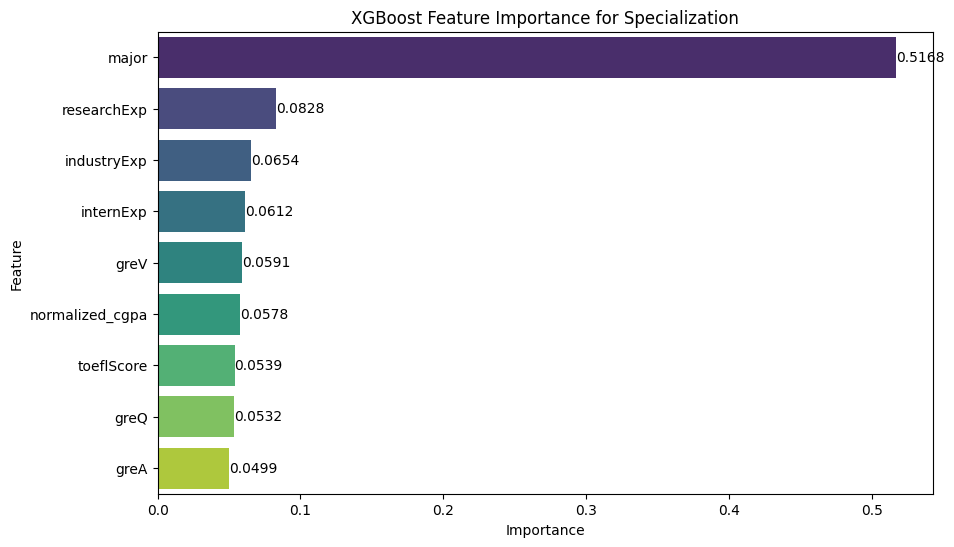

TruncatedSVD Explained Variance Ratio: 0.4603


In [6]:
# Specialization Recommendation
spec_categorical = ['major']
spec_numerical = ['researchExp', 'industryExp', 'toeflScore', 'internExp', 'greV', 'greQ', 'greA', 'normalized_cgpa']

df, label_encoders_spec = encode_categorical_columns(df, spec_categorical)
df, scaler_spec = scale_numerical_columns(df, spec_numerical)

min_samples_per_class = 20
valid_classes = df['specialization_category'].value_counts()
valid_classes = valid_classes[valid_classes >= min_samples_per_class].index
df = df[df['specialization_category'].isin(valid_classes)]

X_spec = df[spec_categorical + spec_numerical]
y_spec = df['specialization_category']

models_spec, le_y_spec = train_models(*train_test_split(X_spec, y_spec, test_size=0.2, random_state=42, stratify=y_spec), "Specialization")

In [10]:
import os
spec_save_dir = "models/major_models"

os.makedirs(spec_save_dir, exist_ok=True)

joblib.dump(models_spec["Random Forest"], os.path.join(spec_save_dir, "rf_specialization.pkl"))
models_spec["XGBoost"][0].save_model(os.path.join(spec_save_dir, "xgb_specialization.json"))
joblib.dump(label_encoders_spec, os.path.join(spec_save_dir, "label_encoders_specialization.pkl"))
joblib.dump(scaler_spec, os.path.join(spec_save_dir, "scaler_specialization.pkl"))
joblib.dump(le_y_spec, os.path.join(spec_save_dir, "le_y_spec.pkl"))

['models/major_models\\le_y_spec.pkl']